In [113]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Compose, Normalize
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import time
import torch.optim as optim
from tqdm import tqdm
from torch.optim import lr_scheduler

In [114]:
#Allow autofill on kaggle
%config Completer.use_jedi = False

In [115]:
# Helper functions to load data into gpu if available

def get_default_device():
  #Pick GPU if available, else CPU
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  #Move tensor(s) to chosen device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    #Wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
      
    def __iter__(self):
    #Yield a batch of data after moving it to device
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
    #Number of batches
        return len(self.dl)

In [116]:
#Loading Dataset
transform = Compose(
    [ToTensor(),
     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

dataset = CIFAR10(root='data/', train=True,download=True, transform=transform)

val_size = 8000
train_size = len(dataset) - val_size
trainset, valset = random_split(dataset, [train_size, val_size])
trainloader = DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=4, pin_memory = True)
valloader = DataLoader(valset, batch_size=batch_size, num_workers=4, pin_memory=True)

testset = CIFAR10(root='data/', train=False,download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=4, pin_memory = True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = get_default_device()
print(device)

Files already downloaded and verified
Files already downloaded and verified
cuda


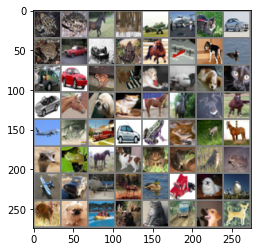

frog  frog  horse deer  plane plane cat   car   frog  car   ship  frog  horse plane dog   bird  car   car   frog  dog   dog   plane dog   cat   car   horse dog   cat   horse horse frog  horse plane cat   truck car   frog  cat   deer  horse bird  frog  horse dog   frog  frog  bird  frog  plane car   plane deer  bird  truck dog   plane deer  dog   ship  deer  cat   truck dog   dog  


In [117]:
#Showing few images in the loaded data
def imshow(img):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [118]:
#CNN with 3 convolutional layers and 3 linear layers
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 =  nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)        
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)        
        self.fc1 = nn.Linear(64*4*4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 =  nn.Linear(64, 10)
        self.criterion = nn.CrossEntropyLoss()
        self.dropout = nn.Dropout(p=.5)

    def forward(self, x):
        x = self.pool(F.tanh(self.conv1(x)))
        x = self.pool(F.tanh(self.conv2(x)))
        x = self.pool(F.tanh(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(F.tanh(self.fc1(x)))
        x = self.dropout(F.tanh(self.fc2(x)))
        x = self.fc3(x)
        return x
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = self.criterion(out, labels) # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return loss, acc

    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = self.criterion(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], Time taken :{:.4f}, train_loss : {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['time'], result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [119]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(to_device(batch,device)) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, model, train_loader, val_loader, lr=0.1,momentum = 0.9):
    history = []
    lrs = []
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    end = 0
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    for epoch in range(epochs):
        # Training Phase 
        train_losses = []
        train_accuracy = []
        start = time.time()
        for batch in tqdm(train_loader):
            batch = to_device(batch, device)
            loss,acc= model.training_step(batch)
            train_losses.append(loss)
            train_accuracy.append(acc)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result =  evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accuracy).mean().item()
        end = time.time()
        result['time'] = end - start
        model.epoch_end(epoch, result)
        history.append(result)
        lrs.append(scheduler.get_last_lr())
        scheduler.step()
    return history, end, lrs

In [120]:
begin = time.time()
history, end, lrs = fit(15, net, trainloader, valloader)
print('Finished Training in '+ str(end-begin) + 'secs')

100%|██████████| 657/657 [00:10<00:00, 65.34it/s]


Epoch [0], Time taken :11.9414, train_loss : 2.3163, train_acc: 0.2394, val_loss: 2.2433, val_acc: 0.2491


100%|██████████| 657/657 [00:10<00:00, 65.24it/s]


Epoch [1], Time taken :11.8486, train_loss : 2.2165, train_acc: 0.2686, val_loss: 2.1747, val_acc: 0.2774


100%|██████████| 657/657 [00:10<00:00, 61.96it/s]


Epoch [2], Time taken :12.4624, train_loss : 2.1024, train_acc: 0.2911, val_loss: 2.1761, val_acc: 0.2899


100%|██████████| 657/657 [00:10<00:00, 65.16it/s]


Epoch [3], Time taken :11.9017, train_loss : 2.0157, train_acc: 0.3092, val_loss: 1.9595, val_acc: 0.3299


100%|██████████| 657/657 [00:10<00:00, 64.66it/s]


Epoch [4], Time taken :11.9423, train_loss : 1.9258, train_acc: 0.3349, val_loss: 1.8719, val_acc: 0.3504


100%|██████████| 657/657 [00:10<00:00, 61.19it/s]


Epoch [5], Time taken :12.5335, train_loss : 1.8368, train_acc: 0.3579, val_loss: 1.8415, val_acc: 0.3635


100%|██████████| 657/657 [00:10<00:00, 65.21it/s]


Epoch [6], Time taken :11.8976, train_loss : 1.7818, train_acc: 0.3730, val_loss: 1.7674, val_acc: 0.3665


100%|██████████| 657/657 [00:10<00:00, 65.15it/s]


Epoch [7], Time taken :12.1089, train_loss : 1.7175, train_acc: 0.3889, val_loss: 1.6681, val_acc: 0.4005


100%|██████████| 657/657 [00:10<00:00, 61.25it/s]


Epoch [8], Time taken :12.6386, train_loss : 1.6529, train_acc: 0.4162, val_loss: 1.6394, val_acc: 0.4226


100%|██████████| 657/657 [00:10<00:00, 63.08it/s]


Epoch [9], Time taken :12.3032, train_loss : 1.6165, train_acc: 0.4220, val_loss: 1.5991, val_acc: 0.4284


100%|██████████| 657/657 [00:10<00:00, 60.55it/s]


Epoch [10], Time taken :12.7319, train_loss : 1.5760, train_acc: 0.4418, val_loss: 1.5771, val_acc: 0.4319


100%|██████████| 657/657 [00:10<00:00, 65.53it/s]


Epoch [11], Time taken :11.8151, train_loss : 1.5388, train_acc: 0.4529, val_loss: 1.5409, val_acc: 0.4404


100%|██████████| 657/657 [00:10<00:00, 64.53it/s]


Epoch [12], Time taken :12.0034, train_loss : 1.5042, train_acc: 0.4625, val_loss: 1.5250, val_acc: 0.4535


100%|██████████| 657/657 [00:10<00:00, 61.70it/s]


Epoch [13], Time taken :12.4235, train_loss : 1.4712, train_acc: 0.4772, val_loss: 1.4624, val_acc: 0.4775


100%|██████████| 657/657 [00:10<00:00, 64.46it/s]


Epoch [14], Time taken :11.9845, train_loss : 1.4426, train_acc: 0.4854, val_loss: 1.4625, val_acc: 0.4789
Finished Training in 182.75072240829468secs


In [121]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

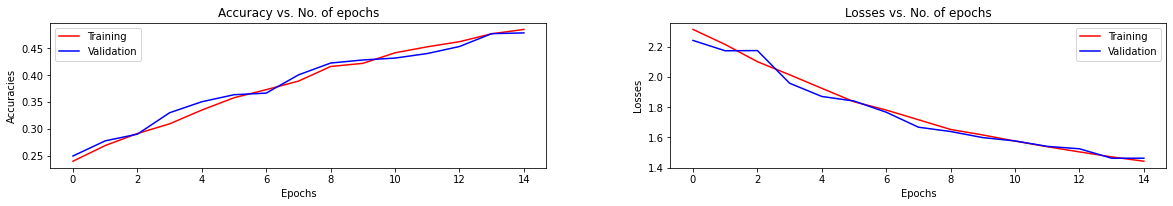

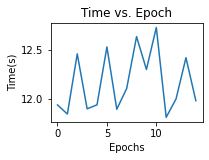

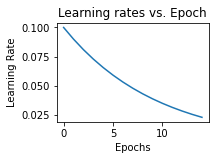

In [122]:
def plot_results(history, lrs):
    val_accs = [x['val_acc'] for x in history]
    train_accs = [x['train_acc'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    train_losses = [x['train_loss'] for x in history] 
    time_taken = [x['time'] for x in history]
    plt.figure(figsize=(20,6))
    plt.subplots_adjust(wspace= 0.25, hspace= 0.25)
    plt.subplot(221)
    plt.plot(train_accs, '-r')
    plt.plot(val_accs, '-b')
    ax = plt.gca()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracies')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')
    
    plt.subplot(222)
    plt.plot(train_losses, '-r')
    plt.plot(val_losses, '-b')
    ax = plt.gca()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Losses')
    plt.legend(['Training', 'Validation'])
    plt.title('Losses vs. No. of epochs')
    plt.show()
    
    plt.subplot(223)
    plt.plot(time_taken)
    ax = plt.gca()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Time(s)')
    plt.title('Time vs. Epoch')
    plt.show()
    
    plt.subplot(224)
    plt.plot(lrs)
    ax = plt.gca()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Learning Rate')
    plt.title('Learning rates vs. Epoch')
    plt.show()
              
plot_results(history, lrs)

In [123]:
net = Net()
net.load_state_dict(torch.load(PATH))
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [124]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        data = to_device(data, device)
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 48 %


In [125]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        data = to_device(data, device)
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 59.6 %
Accuracy for class: car   is 58.9 %
Accuracy for class: bird  is 34.5 %
Accuracy for class: cat   is 31.6 %
Accuracy for class: deer  is 16.6 %
Accuracy for class: dog   is 44.7 %
Accuracy for class: frog  is 63.1 %
Accuracy for class: horse is 48.3 %
Accuracy for class: ship  is 63.8 %
Accuracy for class: truck is 63.6 %
